<a href="https://colab.research.google.com/github/kode-git/ViT-emotion-recognition/blob/main/ViT_Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ViT Face Emotion Recognition


## 1 Introduction

ViT Face Emotion Recognition is a project based on the use of transformers for image classification. In our project we demostrates that transformers are able to classify some images in tasks like emotion recognition. The project has 3 different datasets in input that must be integrated in one and homogeneus dataset. Firstly, we need to resize images using a 224x224 total dimension because transformers has a same linear size for the input and the patching phase needs the same amount of data. The result subsets must be merged in one dataset called ViT. 

ViT Dataset is formed by 8 different classes integrated by 3 different subsets:
1. FER-2013: Fer2013 contains approximately 30,000 facial RGB images of different expressions with size restricted to 48×48, and the main labels of it can be divided into 7 types: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral. The Disgust expression has the minimal number of images – 600, while other labels have nearly 5,000 samples each.
2. CK+: The Extended Cohn-Kanade (CK+) dataset contains some images extrapolated from 593 video sequences from a total of 123 different subjects, ranging from 18 to 50 years of age with a variety of genders and heritage. Each video shows a facial shift from the neutral expression to a targeted peak expression, recorded at 30 frames per second (FPS) with a resolution of either 640x490 or 640x480 pixels. Unfortunately, we don't have the entire generated datasets but we stored only 1000 images with high variance from a kaggle repository. 
3. AffectNet: It is a large facial expression dataset with 40k images classified in eight categories (neutral, happy, angry, sad, fear, surprise, disgust, contempt) of facial expressions along with the intensity of valence and arousal.

Each dataset focus RGB channels for the coloring and have different sizes and image extensions entirely stored into Google Drive (the total amount of data are around 2 GB). So, we need to estabilish a standard format to manage them in the same way. Finally, we will pass in a data augmentation phase to improve the total amount of images to balance the number of samples for each category. 

Final sections interests in the fine-tuning phase and training on a model which can be saved locally on the drive and used in an external application for the real-time classification on an ad-hoc application.



## 2. Data Retrieval

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import keras
import os
import cv2
import glob
from google.colab import drive

In [ ]:
!pip3 install Pillow

In [ ]:
from PIL import Image

Data sources about datasets described in the previous section are stored in Google Drive, so we need to manage file in a shared directory and integrate them in a single units with merging images of the same classes from different datasets.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The next snippet of code describes important functions used for the integration, ImageWorker is a class which we can use to convert the size format of an image (to make them in a standard dimension), changing the extension of an image and can evaluate the number of images per class in each of interested datasets.

In [ ]:

class ImageWorker():

    def __init__(self) -> None:
         pass

    def format_converter(self, path, format_img, source_type, dest_path):
        """format_converter str

        Args:
            path (str): The source path of the images folder 
            format (str): Format of the images in the folder
            source_type (str): Type of the dataset 
            dest_path (str): Destination path to store resized images
        """        
        count = 0
        print("This is:", self.navigate_path(dest_path))

        for file in glob.glob(path + "/*." + format_img):
            img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
            resized = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
            print('Resized writing for', dest_path + "resized_on_" + source_type + "_" + str(count) + "." + format_img )
            cv2.imwrite(dest_path + "resized_on_" + source_type + "_" + str(count) + "."+ format_img, resized)
            count += 1


    def extension_converter(self, path, format_source, format_result, dest_path):
      """extension_converter str

        Args:
            path (str): The source path of the images folder 
            format_source (str): Extension of the images in the folder
            format_result (str): Extension of the result image
            dest_path (str): Destination of the result image
        """        

        # WARNING: During the convertion, we will delete the file with the format_source from the directory
        # specified by the path
       
      for file in glob.glob(path + "/*." + format_source):
          im1 = Image.open(file)
          im1.save(file[0:len(file)-4] + "." + format_result)
          os.remove(file)


    def counter_file_extension(self, path, format):
      """counter_file_extension str

        Args:
            path (str): The source path of the images folder 
            format(str): Extension of the file counting
        """     

      counter = 0
      for file in glob.glob(path + "/*." + format):
          counter += 1
      return counter
      
    def navigate_path(self, path):
        """navigate_path

        Args:
            path (str): Path to navigate and counting number of files

        Returns:
            int : the total amount of file in the directory specified by the path
        """        
        count = 0
        for dir in os.listdir(path):
            if os.path.isfile(os.path.join(path, dir)):
                count += 1
        return count

iw = ImageWorker()

In [ ]:
iw.extension_converter("/content/drive/MyDrive/Datasets/TestNet/anger", "png", "jpg", "/content/drive/MyDrive/Datasets/TestNet/anger")

In [ ]:
iw.counter_file_extension("/content/drive/MyDrive/Datasets/ViT/anger", "jpg")

14963

### 2.1 FER2013 Dataset
FER2013 is a dataset composed by 20.000 images on 7 classes (fear, disgust, sad, happy, neutral, surprise, angry). Images are on size 48x48 with gray-scaled colors palette. The classes variations and features distributions are useful in the merging phase for other classes to obtain a good distribution and normalize the amount of data variation. According to the final classification, the contempt class missed on this kind of dataset.

Loading data from the Google Drive

In [ ]:
num_classes = 7
img_rows,img_cols = 48,48
batch_size = 32

data_dir_fer= '/content/drive/My Drive/Datasets/FER-2013/'

FER2013 don't have so many samples for the disgust class. This observation guarantee a good motivation to merge it with other dataset and, also, for data augmentation phase.

In [ ]:
surprise_fer = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/train/surprise/*.jpg")]
sad_fer = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/train/sad/*.jpg")]
neutral_fer = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/train/neutral/*.jpg")]
happy_fer = [cv2.imread(file) for file in glob.glob(r"/content/drive/My Drive/Datasets/FER-2013/train/happy/*.jpg")]
angry_fer = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/train/angry/*.jpg")]
disgust_fer = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/train/disgust/*.jpg")]

In [ ]:
fear_fer = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/train/fear/*.jpg")]

In [ ]:
print("Total no. of training images: ", len(fear_fer) +len(surprise_fer)+ len(sad_fer)+ len(neutral_fer)+ len(happy_fer)+len(angry_fer))

Total no. of training images:  28339


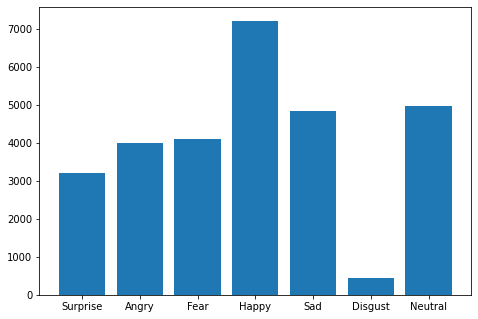

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Surprise', 'Angry', 'Fear', 'Happy', 'Sad', 'Disgust', 'Neutral']
x = [len(surprise_fer), len(angry_fer), len(fear_fer), len(happy_fer), len(sad_fer), len(disgust_fer), len(neutral_fer)]
ax.bar(langs, x)
plt.show()

This dataset is pretty unbalanced for the disgust class, so we needs to manage it in data augmentation or data integration with some samples from other datasets to make a result set which have the same number of samples for each class.

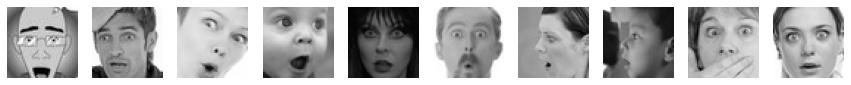

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))

for i in range(0,10):
  ax[i].imshow(cv2.cvtColor(surprise_fer[i], cv2.COLOR_BGR2RGB))
  ax[i].axis('off')

This dataset is pretty good in terms of data views, with some variance on the patterns given by a great variability of facial expression for each category

Actually the image size is 48x48, we need to resize in 256x256 size and put together in the same folder of the other datasets for data integration. We will use our ImageWorker object to do that.

In [ ]:
# Anger class
destination_path_anger = "/content/drive/MyDrive/Datasets/ViT/anger/"
source_path_anger = "/content/drive/MyDrive/Datasets/FER-2013/train/angry/"

# Neutral class
destination_path_neutral = "/content/drive/MyDrive/Datasets/ViT/neutral/"
source_path_neutral = "/content/drive/MyDrive/Datasets/FER-2013/train/neutral/"

# Disgust class
destination_path_disgust = "/content/drive/MyDrive/Datasets/ViT/disgust/"
source_path_disgust = "/content/drive/MyDrive/Datasets/FER-2013/train/disgust/"

# Fear class
destination_path_fear = "/content/drive/MyDrive/Datasets/ViT/fear/"
source_path_fear = "/content/drive/MyDrive/Datasets/FER-2013/train/fear/"

# Happy class
destination_path_happy = "/content/drive/MyDrive/Datasets/ViT/happy/"
source_path_happy = "/content/drive/MyDrive/Datasets/FER-2013/train/happy/"

# Sad class
destination_path_sadness = "/content/drive/MyDrive/Datasets/ViT/sadness/"
source_path_sadness = "/content/drive/MyDrive/Datasets/FER-2013/train/sad/"

# Surprise class
destination_path_surprise = "/content/drive/MyDrive/Datasets/ViT/surprise/"
source_path_surprise = "/content/drive/MyDrive/Datasets/FER-2013/train/surprise/"

# Format of the image in the CK+
format = "jpg"

# Source type
source_type = "fer_2013"

# Formatting and re-assemble for each class of the previous list
iw.format_converter(source_path_anger, format, source_type, destination_path_anger)
iw.format_converter(source_path_neutral, format,source_type, destination_path_neutral)
iw.format_converter(source_path_disgust, format,source_type, destination_path_disgust)
iw.format_converter(source_path_fear, format,source_type, destination_path_fear)
iw.format_converter(source_path_happy, format,source_type, destination_path_happy)
iw.format_converter(source_path_sadness, format,source_type, destination_path_sadness)
iw.format_converter(source_path_surprise, format,source_type, destination_path_surprise)

The data integration phase didn't have any distinction between train and test splitting. So, we can merge the FER-2013 testing set with the training set and split it in a second time. Actually, our interest is to analyze the testing set as well as we did with the training set.

Total no. of training images:  7067


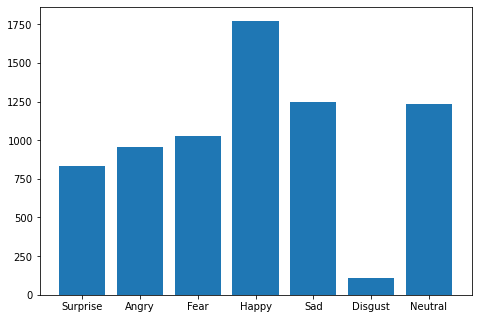

In [ ]:
surprise_fer_2 = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/test/surprise/*.jpg")]
sad_fer_2 = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/test/sad/*.jpg")]
neutral_fer_2 = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/test/neutral/*.jpg")]
happy_fer_2 = [cv2.imread(file) for file in glob.glob(r"/content/drive/My Drive/Datasets/FER-2013/test/happy/*.jpg")]
angry_fer_2 = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/test/angry/*.jpg")]
disgust_fer_2 = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/test/disgust/*.jpg")]
fear_fer_2 = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/test/fear/*.jpg")]

print("Total no. of training images: ", len(fear_fer_2) +len(surprise_fer_2)+ len(sad_fer_2)+ len(neutral_fer_2)+ len(happy_fer_2)+len(angry_fer_2))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Surprise', 'Angry', 'Fear', 'Happy', 'Sad', 'Disgust', 'Neutral']
x = [len(surprise_fer_2), len(angry_fer_2), len(fear_fer_2), len(happy_fer_2), len(sad_fer_2), len(disgust_fer_2), len(neutral_fer_2)]
ax.bar(langs, x)
plt.show()

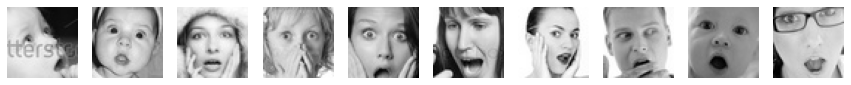

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))

for i in range(0,10):
  ax[i].imshow(cv2.cvtColor(surprise_fer_2[i], cv2.COLOR_BGR2RGB))
  ax[i].axis('off')

In [ ]:
# Anger class
destination_path_anger = "/content/drive/MyDrive/Datasets/ViT/anger/"
source_path_anger = "/content/drive/MyDrive/Datasets/FER-2013/test/angry/"

# Neutral class
destination_path_neutral = "/content/drive/MyDrive/Datasets/ViT/neutral/"
source_path_neutral = "/content/drive/MyDrive/Datasets/FER-2013/test/neutral/"

# Disgust class
destination_path_disgust = "/content/drive/MyDrive/Datasets/ViT/disgust/"
source_path_disgust = "/content/drive/MyDrive/Datasets/FER-2013/test/disgust/"

# Fear class
destination_path_fear = "/content/drive/MyDrive/Datasets/ViT/fear/"
source_path_fear = "/content/drive/MyDrive/Datasets/FER-2013/test/fear/"

# Happy class
destination_path_happy = "/content/drive/MyDrive/Datasets/ViT/happy/"
source_path_happy = "/content/drive/MyDrive/Datasets/FER-2013/test/happy/"

# Sad class
destination_path_sadness = "/content/drive/MyDrive/Datasets/ViT/sadness/"
source_path_sadness = "/content/drive/MyDrive/Datasets/FER-2013/test/sad/"

# Surprise class
destination_path_surprise = "/content/drive/MyDrive/Datasets/ViT/surprise/"
source_path_surprise = "/content/drive/MyDrive/Datasets/FER-2013/test/surprise/"

# Format of the image in the CK+
format = "jpg"

# Source type
source_type = "fer_2013_test"

# Formatting and re-assemble for each class of the previous list
iw.format_converter(source_path_anger, format, source_type, destination_path_anger)
iw.format_converter(source_path_neutral, format,source_type, destination_path_neutral)
iw.format_converter(source_path_disgust, format,source_type, destination_path_disgust)
iw.format_converter(source_path_fear, format,source_type, destination_path_fear)
iw.format_converter(source_path_happy, format,source_type, destination_path_happy)
iw.format_converter(source_path_sadness, format,source_type, destination_path_sadness)
iw.format_converter(source_path_surprise, format,source_type, destination_path_surprise)

### 2.2  CK+ Dataset
A small dataset composed by 981 images on 7 classes (fear, disgust, sad, happy, neutral, surprise, angry). Images are on size 48x48 with gray-scaled colors palette. The classes variations and features distributions are useful in the merging phase for other classes to obtain a good distribution and normalize the amount of data variation. 

In [ ]:
num_classes = 7
img_rows,img_cols = 48,48
batch_size = 32

data_dir_ck = '/content/drive/My Drive/Datasets/CK+48'

In [ ]:
surprise_ck = [cv2.imread(file) for file in glob.glob(r'/content/drive/MyDrive/Datasets/CK+48/surprise/*.png')]
anger_ck = [cv2.imread(file) for file in glob.glob(r'/content/drive/MyDrive/Datasets/CK+48/anger/*.png')]
contempt_ck = [cv2.imread(file) for file in glob.glob(r'/content/drive/MyDrive/Datasets/CK+48/contempt/*.png')]
fear_ck = [cv2.imread(file) for file in glob.glob(r'/content/drive/MyDrive/Datasets/CK+48/fear/*.png')]
happy_ck = [cv2.imread(file) for file in glob.glob(r'/content/drive/MyDrive/Datasets/CK+48/happy/*.png')]
sad_ck = [cv2.imread(file) for file in glob.glob(r'/content/drive/MyDrive/Datasets/CK+48/sadness/*.png')]
disgust_ck = [cv2.imread(file) for file in glob.glob(r'/content/drive/MyDrive/Datasets/CK+48/disgust/*.png')]

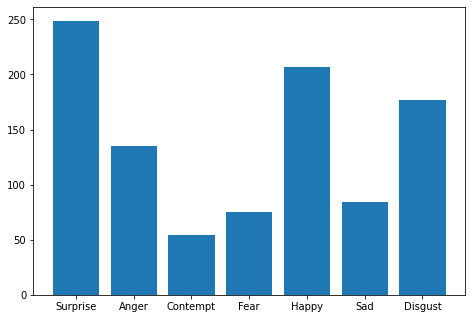

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Surprise', 'Anger', 'Contempt', 'Fear', 'Happy', 'Sad', 'Disgust']
x = [len(surprise_ck), len(anger_ck), len(contempt_ck), len(fear_ck), len(happy_ck), len(sad_ck), len(disgust_ck)]
ax.bar(langs, x)
plt.show()

In [ ]:
print('Total size of the CK+ dataset: ', len(surprise_ck) + len(anger_ck) + len(contempt_ck) + len(fear_ck) + len(happy_ck) + len(sad_ck) + len(disgust_ck))

Total size of the CK+ dataset:  981


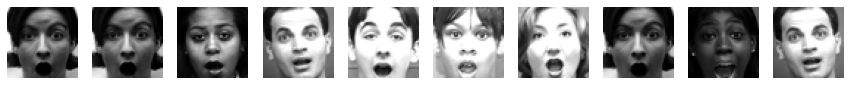

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))

for i in range(0,10):
  ax[i].imshow(cv2.cvtColor(surprise_ck[i], cv2.COLOR_BGR2RGB))
  ax[i].axis('off')

Actually, the image size is 48x48, to retrieve some data in a common format, we will try to resize them mantaining pixels patterns for data processing. The new size is 224x224 that should mantain in a good way features of the samples. We will save the resized images in a new folder on the drive.

In [ ]:
!mkdir /content/drive/MyDrive/Datasets/ViT/contempt

In [ ]:
# Anger class
destination_path_anger = "/content/drive/MyDrive/Datasets/ViT/anger/"
source_path_anger = "/content/drive/MyDrive/Datasets/CK+48/anger/"

# Contempt class
destination_path_contempt = "/content/drive/MyDrive/Datasets/ViT/contempt/"
source_path_contempt = "/content/drive/MyDrive/Datasets/CK+48/contempt/"

# Disgust class
destination_path_disgust = "/content/drive/MyDrive/Datasets/ViT/disgust/"
source_path_disgust = "/content/drive/MyDrive/Datasets/CK+48/disgust/"

# Fear class
destination_path_fear = "/content/drive/MyDrive/Datasets/ViT/fear/"
source_path_fear = "/content/drive/MyDrive/Datasets/CK+48/fear/"

# Happy class
destination_path_happy = "/content/drive/MyDrive/Datasets/ViT/happy/"
source_path_happy = "/content/drive/MyDrive/Datasets/CK+48/happy/"

# Sad class
destination_path_sadness = "/content/drive/MyDrive/Datasets/ViT/sadness/"
source_path_sadness = "/content/drive/MyDrive/Datasets/CK+48/sadness/"

# Surprise class
destination_path_surprise = "/content/drive/MyDrive/Datasets/ViT/surprise/"
source_path_surprise = "/content/drive/MyDrive/Datasets/CK+48/surprise/"

# Format of the image in the CK+
format = "png"

# Source type
source_type = "ck_plus"

# Formatting and re-assemble for each class of the previous list
iw.format_converter(source_path_anger, format, source_type, destination_path_anger)
iw.format_converter(source_path_disgust, format,source_type, destination_path_disgust)
iw.format_converter(source_path_fear, format,source_type, destination_path_fear)
iw.format_converter(source_path_happy, format,source_type, destination_path_happy)
iw.format_converter(source_path_sadness, format,source_type, destination_path_sadness)
iw.format_converter(source_path_surprise, format,source_type, destination_path_surprise)

In [ ]:
iw.format_converter(source_path_contempt, format,source_type, destination_path_contempt)

At the end of data integration between FER-2013 and CK+48 sets, we got the following amount of total samples described in the following snippet of code

In [ ]:
def plot_ViT():
  angry_l = iw.navigate_path("/content/drive/MyDrive/Datasets/ViT/anger")
  contempt_l = iw.navigate_path("/content/drive/MyDrive/Datasets/ViT/contempt")
  disgust_l = iw.navigate_path("/content/drive/MyDrive/Datasets/ViT/disgust")
  fear_l = iw.navigate_path("/content/drive/MyDrive/Datasets/ViT/fear")
  happy_l = iw.navigate_path("/content/drive/MyDrive/Datasets/ViT/happy")
  neutral_l = iw.navigate_path("/content/drive/MyDrive/Datasets/ViT/neutral")
  sad_l = iw.navigate_path("/content/drive/MyDrive/Datasets/ViT/sadness")
  surprise_l = iw.navigate_path("/content/drive/MyDrive/Datasets/ViT/surprise")
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  langs = ['Surprise', 'Angry', 'Fear', 'Happy', 'Sad', 'Disgust', 'Neutral', 'Contempt']
  x = [surprise_l, angry_l, fear_l, happy_l, sad_l, disgust_l, neutral_l, contempt_l]
  ax.bar(langs, x)
  plt.show()
  print('\nTotal amount of samples: ', surprise_l + angry_l + fear_l + happy_l + sad_l + disgust_l + neutral_l + contempt_l)

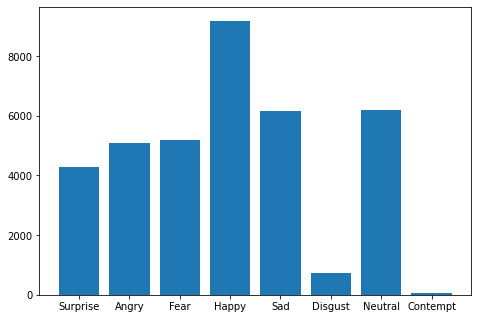


Total amount of samples:  36934


In [ ]:
plot_ViT()

### 2.3 AffectNet Dataset
AffectNet dataset is formed by some samples in different sizes, high-quality images in gray-scale or colored in RGB range. It has 8 different classes (surprise, angry, sad, contempt, disgust, fear, neutral, happy). As the FER-2013, there is a division between testing and training set, we will merge it as well as we did with FER subsets. Furthermore, we resize the different sizes of its images in 256x256 to estabilish the same amount of pixels for each sample.

In [ ]:
def plot_AffectNet(flag=""):
  dir = "train_class"
  if flag == "val":
    dir = "val_class"
  angry_l = iw.navigate_path("/content/drive/MyDrive/Datasets/AffectNet/" + dir + "/anger")
  contempt_l = iw.navigate_path("/content/drive/MyDrive/Datasets/AffectNet/" + dir + "/contempt")
  disgust_l = iw.navigate_path("/content/drive/MyDrive/Datasets/AffectNet/" + dir + "/disgust")
  fear_l = iw.navigate_path("/content/drive/MyDrive/Datasets/AffectNet/" + dir + "/fear")
  happy_l = iw.navigate_path("/content/drive/MyDrive/Datasets/AffectNet/" + dir + "/happy")
  neutral_l = iw.navigate_path("/content/drive/MyDrive/Datasets/AffectNet/" + dir + "/neutral")
  sad_l = iw.navigate_path("/content/drive/MyDrive/Datasets/AffectNet/" + dir + "/sadness")
  surprise_l = iw.navigate_path("/content/drive/MyDrive/Datasets/AffectNet/" + dir + "/surprise")
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  langs = ['Surprise', 'Angry', 'Fear', 'Happy', 'Sad', 'Disgust', 'Neutral', 'Contempt']
  x = [surprise_l, angry_l, fear_l, happy_l, sad_l, disgust_l, neutral_l, contempt_l]
  ax.bar(langs, x)
  plt.show()
  print('\nTotal amount of samples: ', surprise_l + angry_l + fear_l + happy_l + sad_l + disgust_l + neutral_l + contempt_l)

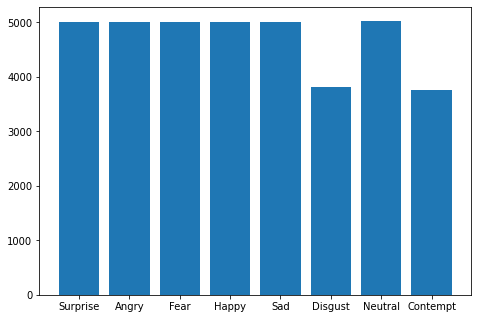


Total amount of samples:  37583


In [ ]:
plot_AffectNet()

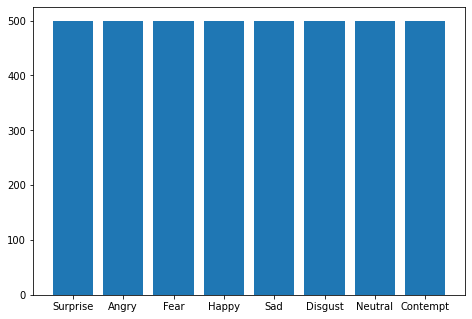


Total amount of samples:  4000


In [ ]:
plot_AffectNet("val")

In [ ]:
# Format of the image in the AffectNet
format = "jpg"


In [ ]:
# Surprise train subset class
destination_path_surprise = "/content/drive/MyDrive/Datasets/ViT/surprise/"
source_path_surprise = "/content/drive/MyDrive/Datasets/AffectNet/train_class/surprise/"

# Source type
source_type = "affectnet"

# Formatting and re-assemble for each class of the previous list
iw.format_converter(source_path_surprise, format, source_type, destination_path_surprise)

# Surprise test subset class
destination_path_surprise = "/content/drive/MyDrive/Datasets/ViT/surprise/"
source_path_surprise = "/content/drive/MyDrive/Datasets/AffectNet/val_class/surprise/"

source_type = "affectnet_2"

# Formatting and re-assemble for each class of the previous list
iw.format_converter(source_path_surprise, format, source_type, destination_path_surprise)

In [ ]:
# Anger train subset class
destination_path_anger = "/content/drive/MyDrive/Datasets/ViT/anger/"
source_path_anger = "/content/drive/MyDrive/Datasets/AffectNet/train_class/anger/"

# Contempt train subset class
destination_path_contempt = "/content/drive/MyDrive/Datasets/ViT/contempt/"
source_path_contempt = "/content/drive/MyDrive/Datasets/AffectNet/train_class/contempt/"

# Disgust train subset class
destination_path_disgust = "/content/drive/MyDrive/Datasets/ViT/disgust/"
source_path_disgust = "/content/drive/MyDrive/Datasets/AffectNet/train_class/disgust/"

# Fear train subset class
destination_path_fear = "/content/drive/MyDrive/Datasets/ViT/fear/"
source_path_fear = "/content/drive/MyDrive/Datasets/AffectNet/train_class/fear/"

# Happy train subset class
destination_path_happy = "/content/drive/MyDrive/Datasets/ViT/happy/"
source_path_happy = "/content/drive/MyDrive/Datasets/AffectNet/train_class/happy/"

# Neutral train subset class
destination_path_neutral = "/content/drive/MyDrive/Datasets/ViT/neutral/"
source_path_neutral = "/content/drive/MyDrive/Datasets/AffectNet/train_class/neutral/"

# Sadness train subset class
destination_path_sadness = "/content/drive/MyDrive/Datasets/ViT/sadness/"
source_path_sadness = "/content/drive/MyDrive/Datasets/AffectNet/train_class/sadness/"

# Source type
source_type = "affectnet"

# Formatting and re-assemble for each class of the previous list
iw.format_converter(source_path_anger, format, source_type, destination_path_anger)
iw.format_converter(source_path_contempt, format, source_type, destination_path_contempt)
iw.format_converter(source_path_disgust, format, source_type, destination_path_disgust)
iw.format_converter(source_path_fear, format, source_type, destination_path_fear)
iw.format_converter(source_path_happy, format, source_type, destination_path_happy)
iw.format_converter(source_path_neutral, format, source_type, destination_path_neutral)
iw.format_converter(source_path_sadness, format, source_type, destination_path_sadness)

In [ ]:
# Anger test subset class
destination_path_surprise = "/content/drive/MyDrive/Datasets/ViT/anger/"
source_path_surprise = "/content/drive/MyDrive/Datasets/AffectNet/val_class/anger/"

# Contempt train subset class
destination_path_contempt = "/content/drive/MyDrive/Datasets/ViT/contempt/"
source_path_contempt = "/content/drive/MyDrive/Datasets/AffectNet/val_class/contempt/"

# Disgust train subset class
destination_path_disgust = "/content/drive/MyDrive/Datasets/ViT/disgust/"
source_path_disgust = "/content/drive/MyDrive/Datasets/AffectNet/val_class/disgust/"

# Fear train subset class
destination_path_fear = "/content/drive/MyDrive/Datasets/ViT/fear/"
source_path_fear = "/content/drive/MyDrive/Datasets/AffectNet/val_class/fear/"

# Happy train subset class
destination_path_happy = "/content/drive/MyDrive/Datasets/ViT/happy/"
source_path_happy = "/content/drive/MyDrive/Datasets/AffectNet/val_class/happy/"

# Neutral train subset class
destination_path_neutral = "/content/drive/MyDrive/Datasets/ViT/neutral/"
source_path_neutral = "/content/drive/MyDrive/Datasets/AffectNet/val_class/neutral/"

# Sadness train subset class
destination_path_sadness = "/content/drive/MyDrive/Datasets/ViT/sadness/"
source_path_sadness = "/content/drive/MyDrive/Datasets/AffectNet/val_class/sadness/"

source_type = "affectnet_2"

# Formatting and re-assemble for each class of the previous list
iw.format_converter(source_path_anger, format, source_type, destination_path_anger)
iw.format_converter(source_path_contempt, format, source_type, destination_path_contempt)
iw.format_converter(source_path_disgust, format, source_type, destination_path_disgust)
iw.format_converter(source_path_fear, format, source_type, destination_path_fear)
iw.format_converter(source_path_happy, format, source_type, destination_path_happy)
iw.format_converter(source_path_neutral, format, source_type, destination_path_neutral)
iw.format_converter(source_path_sadness, format, source_type, destination_path_sadness)

### 2.4 ViT Dataset
ViT is the result datasets composed by the integration of images of the 3 different data sources described in the introduction section. It is formed by a mix of gray-scale and rgb-based images with same dimensions divided by subdirectories to divide different classes. We don't have any training/testing splitting yet.

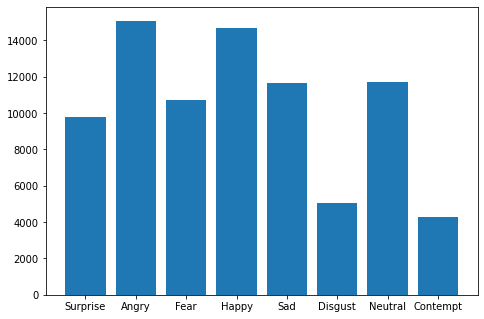


Total amount of samples:  83017


In [ ]:
plot_ViT()

## 3. Data Analysis


Given the result dataset, we are ready to manage samples with procedures of data augmentation and pre-processing to prepare samples for the proposed models.

Firstly, we need to transform images in a common extension. Data from AffectNet and FER-2013 have JPG images meanwhile CK+ has PNG extensions. Considering the total amount of jpg-type images, we will convert every samples in this format.

About the total amount of data are 83.017 different samples, categories like Disgust or Contempt are around 5500 and 5800 different samples respectively. Actually, the dataset is unbalanced so, to solve that, we will execute data augmentation procedures to improves the total number of these categories.

In [ ]:
categories_data = {'anger' : {}, 'contempt' : {}, 'fear' : {}, 'disgust' : {}, 'happy' : {}, 'neutral' : {}, 'sadness' : {}, 'surprise' : {}}
for el in categories_data.keys():
   categories_data[el]['png_count'] = iw.counter_file_extension("/content/drive/MyDrive/Datasets/ViT/" + el, "png")
   categories_data[el]['jpg_count'] = iw.counter_file_extension("/content/drive/MyDrive/Datasets/ViT/" + el, "jpg")
categories_data

{'anger': {'jpg_count': 14963, 'png_count': 135},
 'contempt': {'jpg_count': 4250, 'png_count': 54},
 'disgust': {'jpg_count': 4850, 'png_count': 177},
 'fear': {'jpg_count': 10631, 'png_count': 75},
 'happy': {'jpg_count': 14489, 'png_count': 207},
 'neutral': {'jpg_count': 11728, 'png_count': 0},
 'sadness': {'jpg_count': 11577, 'png_count': 84},
 'surprise': {'jpg_count': 9548, 'png_count': 249}}

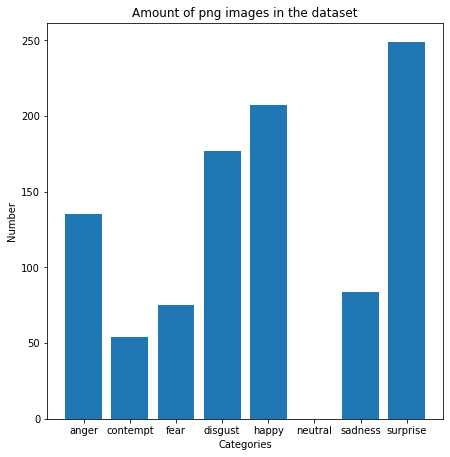

In [ ]:
fig = plt.figure(figsize=(5.5,5.5))
ax = fig.add_axes([0,0,1,1])
langs = [el for el in categories_data.keys()]
x = [categories_data[el]['png_count'] for el in categories_data.keys()]
ax.bar(langs, x)
plt.title('Amount of png images in the dataset')
plt.ylabel('Number')
plt.xlabel('Categories')
plt.show()

The total amount of data in png are pretty small. That's because we have some samples given by CK+ in this format. CK+ didn't focus so many data, so changing these images in .jpg didn't have huge impact on the dataset noise.



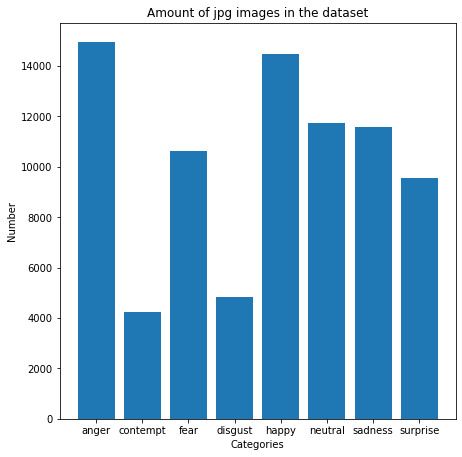

In [ ]:
fig = plt.figure(figsize=(5.5,5.5))
ax = fig.add_axes([0,0,1,1])
langs = [el for el in categories_data.keys()]
x = [categories_data[el]['jpg_count'] for el in categories_data.keys()]
ax.bar(langs, x)
plt.title('Amount of jpg images in the dataset')
plt.ylabel('Number')
plt.xlabel('Categories')
plt.show()

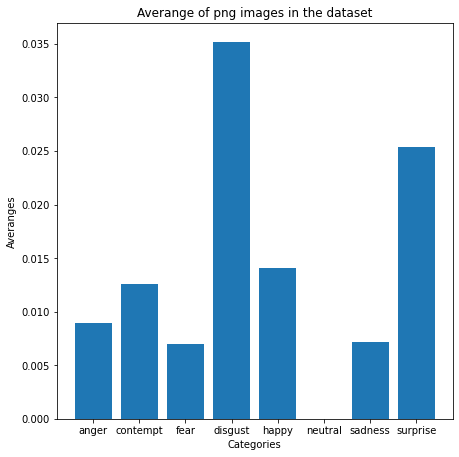

In [ ]:
fig = plt.figure(figsize=(5.5,5.5))
ax = fig.add_axes([0,0,1,1])
langs = [el for el in categories_data.keys()]
x = [categories_data[el]['png_count']/(categories_data[el]['png_count']+categories_data[el]['jpg_count']) for el in categories_data.keys()]
ax.bar(langs, x)
plt.title('Averange of png images in the dataset')
plt.ylabel('Averanges')
plt.xlabel('Categories')
plt.show()

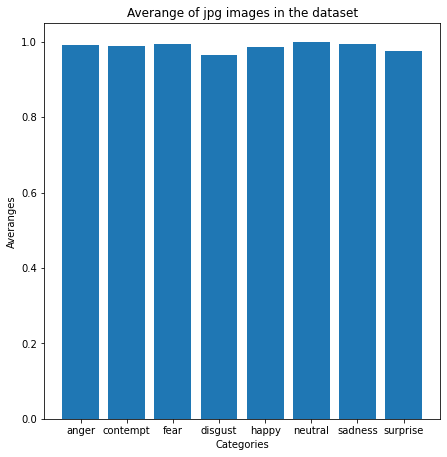

In [ ]:
fig = plt.figure(figsize=(5.5,5.5))
ax = fig.add_axes([0,0,1,1])
langs = [el for el in categories_data.keys()]
x = [categories_data[el]['jpg_count']/(categories_data[el]['png_count']+categories_data[el]['jpg_count']) for el in categories_data.keys()]
ax.bar(langs, x)
plt.title('Averange of jpg images in the dataset')
plt.ylabel('Averanges')
plt.xlabel('Categories')
plt.show()

A final consideration about the amount of data type in png extension is the less impact in according of the total number of the dataset. According to the last 2 plots, the averange of images in png extension are max in 0.03%. It is good to consider that categories with the maximum averange value are disgust and surprise, that are classes with a small impact for the AffectNet dataset. Generally, converted images can add some noise but, given the small amount of this kind of noised samples, we will mantain them in according to the final application of the model and give an additional variability on the webcam quality.

## 4. Data Augmentation

Data Augmentation is the phase where we will improves the total amount of images for categories with a small number of samples and defines a final balanced version of the ViT dataset.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

def generator(path, format_img, dest_path,source_type):
    gen = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            rotation_range=10,
            width_shift_range=0.2,
            height_shift_range=0.2,
            brightness_range=(0.2,0.8),
            zoom_range=0.2,
            horizontal_flip=True
            #preprocessing_function=
            )
    print("This is:", iw.navigate_path(dest_path))
    if iw.navigate_path(dest_path) == 0:
        os.mkdir(dest_path)
    for file in glob.glob(path + "\\*." + format_img):
        img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
        print(img.shape)
         
        # convert to numpy array
        # expand dimension to one sample
        samples = expand_dims(img, 0)
        iterator = gen.flow(samples,batch_size=1)
        for i in range(9):
            plt.subplot(330 + 1 + i)
            batch = iterator.next()
            image = batch[0].astype('uint8')
            cv2.imwrite(dest_path + "augmented_on_" + source_type + "_" + str(1) + "."+ format_img, image)

generator("/content/drive/MyDrive/Datasets/TestNet/anger", "jpg", "/content/drive/MyDrive/Datasets/TestNet/anger", "jpg")

This is: 5


## 5. Loading the final dataset

## 6. Training Transformer

## 7. Evaluation

## 8. Export Model